In [33]:
!pip install torchsummary

In [1]:
import glob
import json
import os
import random as rnd
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

import torch.nn as nn
import torch.nn.functional as F

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 64
        self.img_size = (512, 60)
        self.crop = self.img_size < (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 2
        self.norm = False
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.n_epochs = 60
        self.input_shape = (*self.img_size, self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
cfg.input_shape

(512, 60, 1)

In [5]:
root_dir = "/app/_data/artist_data/"
mod_dir = "/app/_data/artist_data/models/test_arch/tripl_5/"

In [6]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))
train = train[train["artistid_count"] != 1].reset_index(drop=True)

## train_val_split

In [7]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

In [8]:
train_df = train[train["fold"] != cfg.fold].reset_index(drop=True)
val_df = train[train["fold"] == cfg.fold].reset_index(drop=True)

## DataGenerator

In [11]:
class DataLoader:
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
        shuffle=True,
        debug=True,
        transpose=True,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.shuffle = shuffle
        self.artist_ids = self.data["artistid"].unique().tolist()
        self.default_img_size = (512, 81)
        self.artis2path = self.data.groupby("artistid").agg(list)["path"].to_dict()
        self.path2artist = self.data.set_index("path")["artistid"].to_dict()
        self.paths = self.data["path"].tolist()
        self.debug = debug
        self.transpose = transpose
        self.device = "cpu"
        if self.shuffle:
            np.random.shuffle(self.paths)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        if self.transpose:
            img = img.transpose(1, 0)
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def make_labels(self, array):
        array = np.expand_dims(array, -1)
        dists = (
            np.sum(np.square(array), axis=1)
            + np.sum(np.square(array.T), axis=0)
            - 2.0 * np.matmul(array, array.T)
        )
        labels = np.where(dists == 0, 0, 1)
        return labels

    def __getitem__(self, batch_ix):
        artist_ids = rnd.sample(self.artist_ids, self.batch_size // 4)
        paths = (
            self.data.query("artistid in @artist_ids").sample(frac=1)["path"].tolist()
        )
        if len(paths) >= self.batch_size:
            batch_paths = rnd.sample(paths, self.batch_size)
        else:
            paths.extend(rnd.sample(self.paths, self.batch_size - len(paths)))
            batch_paths = paths
        imgs, labels = [], []
        for i in range(self.batch_size):
            path = batch_paths[i]
            imgs.append(self.load_img(path))
            labels.append(self.path2artist[path])
        imgs = np.array(imgs)
        labels = self.make_labels(np.array(labels))
        return torch.tensor(imgs, device=self.device), torch.tensor(
            labels, device=self.device
        )

In [12]:
train_gen = DataLoader(
    data=train_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    debug=False,
    transpose=False,
)
val_gen = DataLoader(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    debug=False,
    transpose=False,
)

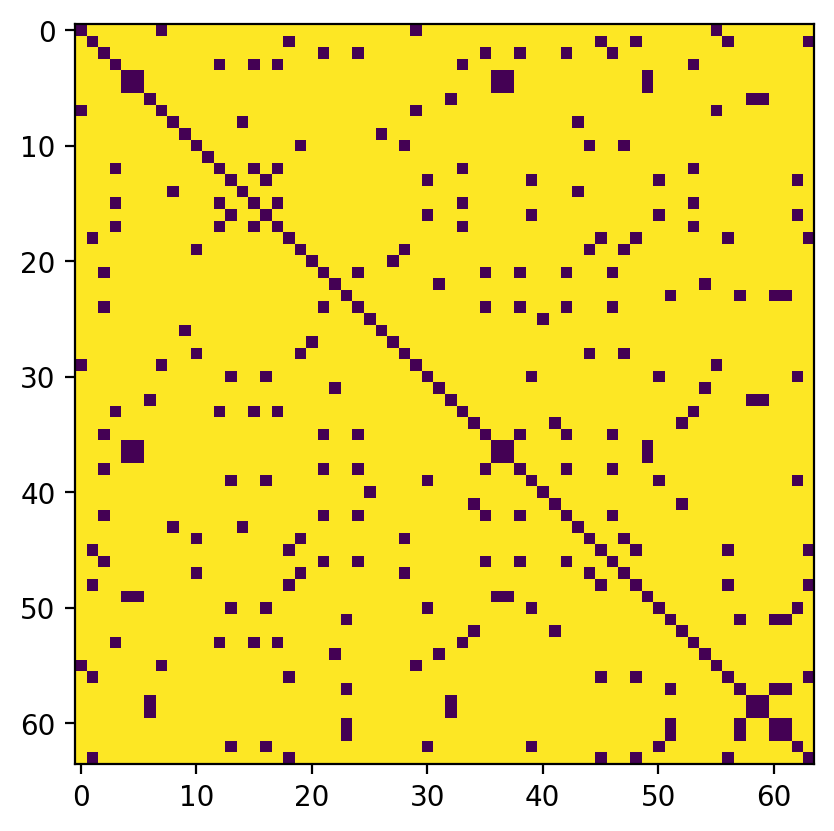

In [13]:
imgs, labels = train_gen.__getitem__(9)
imgs.shape
plt.imshow(labels.detach().numpy())
plt.show();

## Model

In [37]:
class EmbNet(nn.Module):
    def __init__(
        self,
        input_shape,
        output_features_size,
        kernel_size=5,
        dropout_rate=0.1,
        embedding_len=1024,
        activation_fn="relu",
        padding="same",
        dense_activation="relu",
    ):
        super().__init__()
        self.output_features_size = output_features_size
        self.conv_1 = nn.Conv1d(
            in_channels = 512, out_channels = 512, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            512,
            1024,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(
            1024,
            1024,
            kernel_size=kernel_size,
            padding=1,
        )
        self.conv_4 = nn.Conv1d(
            1024,
            2048,
            kernel_size=kernel_size,
            padding=1,
        )

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis=2)
        return x

In [38]:
embnet = EmbNet(input_shape=cfg.input_shape,
        output_features_size=512,
        kernel_size=5,
        dropout_rate=0.1,
        embedding_len=1024,
        activation_fn="relu",
        padding="same",
        dense_activation="relu",) 

In [39]:
embnet(imgs[:,:,:,0]).shape

torch.Size([64, 2048])

In [40]:
from torchsummary import summary


In [41]:
summary(embnet, input_size = (512, 60), batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 512, 58]       1,311,232
            Conv1d-2             [-1, 1024, 56]       2,622,464
         MaxPool1d-3             [-1, 1024, 28]               0
            Conv1d-4             [-1, 1024, 26]       5,243,904
            Conv1d-5             [-1, 2048, 24]      10,487,808
Total params: 19,665,408
Trainable params: 19,665,408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 1.46
Params size (MB): 75.02
Estimated Total Size (MB): 76.60
----------------------------------------------------------------


In [27]:
def embNet(
    input_shape,
    kernel_size=3,
    dropout_rate=0.1,
    embedding_len=1024,
    activation_fn="relu",
    padding="same",
    dense_activation="relu",
):
    base_model = tf.keras.models.Sequential(
        [
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                input_shape=input_shape,
                padding=padding,
                name="conv_1",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_2",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_1"
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_3",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_4",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_2"
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_5",
            ),
            keras.layers.Conv2D(
                filters=1,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_6",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(2, 2), strides=1, padding="same", name="max_3"
            ),
            keras.layers.Flatten(),
            keras.layers.Dense(
                embedding_len, activation=dense_activation, name="dense_1"
            ),
        ]
    )
    # x = tf.squeeze(base_model.output, axis=-1)
    # x = tf.reduce_mean(x, axis=-1)
    x = keras.layers.Reshape((1, -1))(base_model.output)
    embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
    return embedding_net

In [13]:
embedding_net = embNet(
    input_shape=cfg.input_shape,
    kernel_size=5,
    dropout_rate=0.1,
    embedding_len=cfg.emb_len,
    activation_fn="relu",
    padding="valid",
    dense_activation="relu",
)

In [14]:
embedding_net.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 512, 60, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 508, 56, 1)        26        
                                                                 
 conv_2 (Conv2D)             (None, 504, 52, 1)        26        
                                                                 
 dropout (Dropout)           (None, 504, 52, 1)        0         
                                                                 
 max_1 (MaxPooling2D)        (None, 504, 52, 1)        0         
                                                                 
 conv_3 (Conv2D)             (None, 500, 48, 1)        26        
                                                                 
 conv_4 (Conv2D)             (None, 496, 44, 1)        26

In [15]:
def low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=4,
    pool_size=7,
    embedding_len=1024,
):
    low_res_1 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=60,
                width=60,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
            ),
            keras.layers.MaxPooling2D(pool_size=pool_size, strides=1, padding=padding),
            keras.layers.Flatten(),
            keras.layers.Dense(embedding_len, activation=activation_fn),
            keras.layers.Reshape((1, -1)),
        ],
        name="low_res_1",
    )
    low_res_2 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=30,
                width=30,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
            ),
            keras.layers.MaxPooling2D(pool_size=pool_size, strides=1, padding=padding),
            keras.layers.Flatten(),
            keras.layers.Dense(embedding_len, activation=activation_fn),
            keras.layers.Reshape((1, -1)),
        ],
        name="low_res_2",
    )
    return low_res_1, low_res_2

In [16]:
low_res_1, low_res_2 = low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=2,
    pool_size=7,
    embedding_len=1024,
)

In [17]:
low_res_1.summary()

Model: "low_res_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 60, 60, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 52, 52, 2)         164       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 2)        0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 4232)              0         
                                                                 
 dense (Dense)               (None, 1024)              43

In [18]:
low_res_2.summary()

Model: "low_res_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 30, 30, 1)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 2)         164       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 2)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              52

In [19]:
def pairwise_distance(feature, squared=False):
    pairwise_distances_squared = tf.math.add(
        tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
        tf.math.reduce_sum(
            tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
        ),
    ) - 2.0 * tf.matmul(feature, tf.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

In [20]:
def siamese_model(input_shape, embedding_net, low_res_1, low_res_2):
    input_img = keras.layers.Input(shape=input_shape, name="img")

    embedding = embedding_net(input_img)
    low1 = low_res_1(input_img)
    low2 = low_res_2(input_img)

    concat = tf.keras.layers.concatenate([embedding, low1, low2], axis=1)
    output = keras.layers.Flatten()(output)

    siamese_net = tf.keras.models.Model(
        inputs=input_img, outputs=output, name="siamese"
    )
    return siamese_net

In [21]:
siamese_net = siamese_model(
    input_shape=cfg.input_shape,
    embedding_net=embedding_net,
    low_res_1=low_res_1,
    low_res_2=low_res_2,
)

In [35]:
def postprocess_model(siamese_net):
    dist = pairwise_distance(siamese_net.output)
    dist = keras.activations.sigmoid(dist)
    model = keras.Model(siamese_net.output, dist, name="postprocess")
    return model

In [45]:
model = postprocess_model(siamese_net)
model.output_shape

(None, None)

In [44]:
siamese_net.output_shape

(None, 3072)

In [23]:
pr = siamese_net(imgs)
pr.shape

TensorShape([64, 3072])

In [24]:
d = pairwise_distance(pr)

In [25]:
d.shape

TensorShape([64, 64])

In [26]:
d = keras.activations.sigmoid(d)

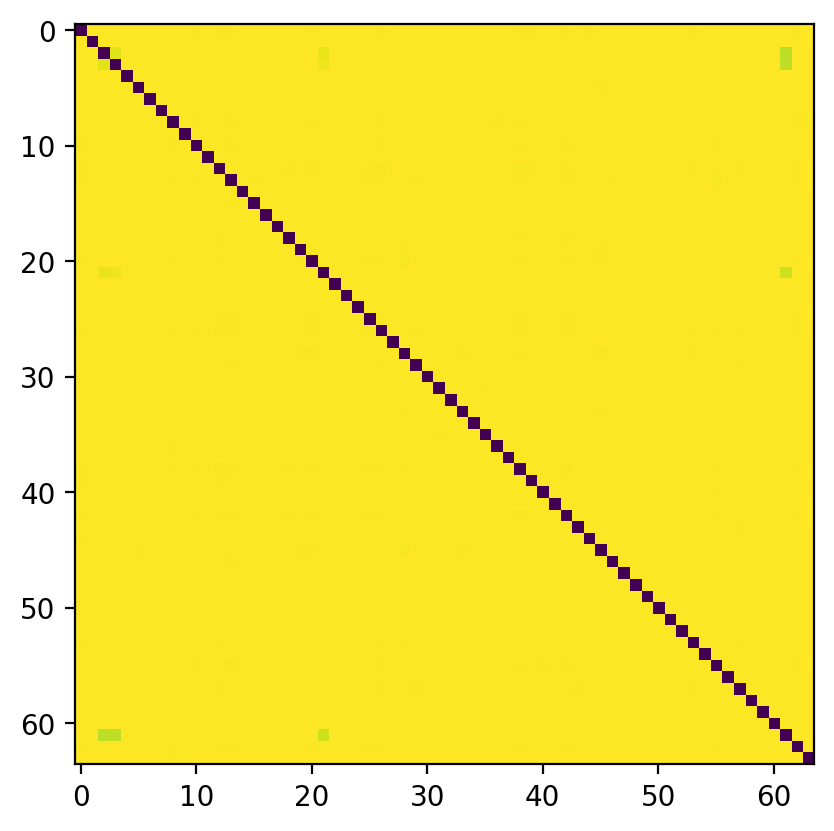

In [27]:
plt.imshow(d.numpy())

In [28]:
d.numpy().max()

0.99999905

In [39]:
def dist_loss():
    def loss(y_true, y_pred):
        dist = pairwise_distance(y_pred)
        dist = keras.activations.sigmoid(dist)
        dist = keras.layers.Flatten()(dist)
        y_true = keras.layers.Flatten()(y_true)
        loss = keras.losses.CategoricalCrossentropy(from_logits=False)(y_true, dist)

    return loss

In [40]:
callbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=10, stop_patience=100
)

In [41]:
siamese_net.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), loss=dist_loss(), metrics="acc"
)

In [42]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [43]:
history = siamese_net.fit(
    x=train_gen,
    steps_per_epoch=train_gen.__len__(),
    validation_data=val_gen,
    callbacks=callbacks,
    epochs=cfg.n_epochs,
    use_multiprocessing=True,
    workers=10,
)

Epoch 1/60


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 140, in __call__
        return losses_utils.compute_weighted_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/losses_utils.py", line 310, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    ValueError: None values not supported.


In [34]:
keras.losses.BinaryCrossentropy(from_logits=False)(labels, d)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4401796>

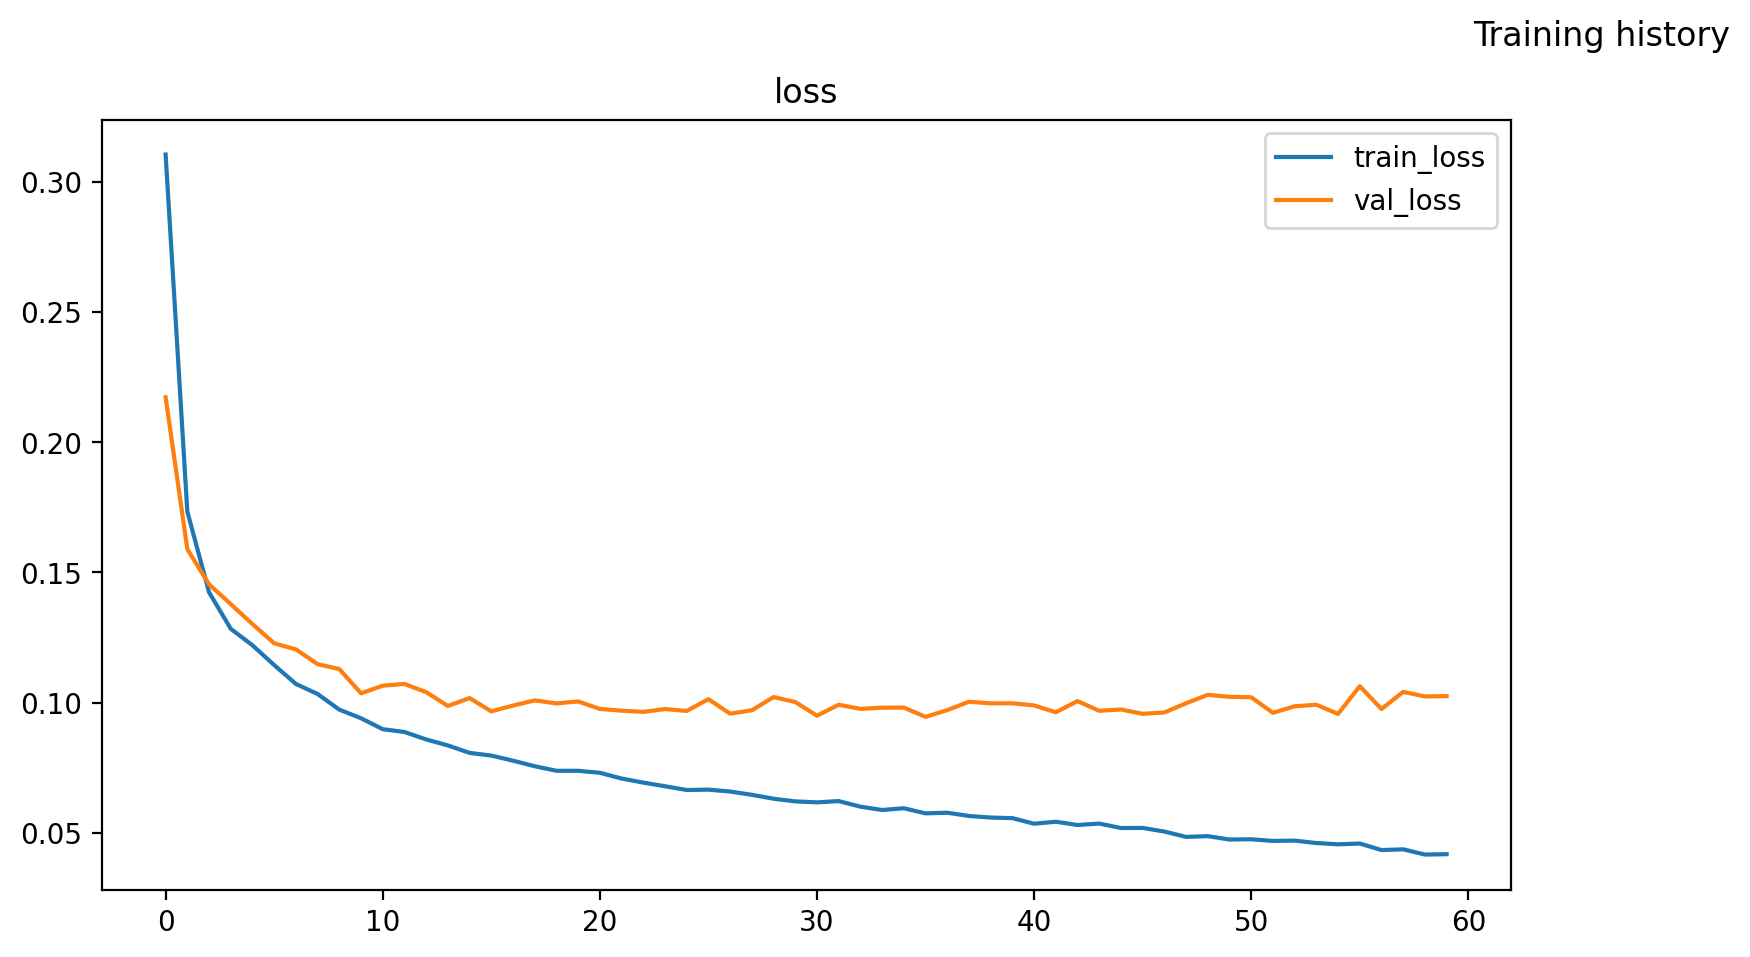

In [24]:
plot_history(history.history)

In [25]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss = np.min(train_history["val_loss"])

    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{min_val_loss}.h5"),
    )
    config = {
        "loss": loss,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{min_val_loss}"), include_optimizer=False)
    print(
        f'min_val_loss = {min_val_loss}, model saved to {os.path.join(mod_dir, f"model_{min_val_loss}")}'
    )

In [26]:
save_params(mod_dir, siamese_net, history, cfg, loss="tripl")

INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497/assets


INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497/assets


min_val_loss = 0.09447911381721497, model saved to /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497


In [27]:
[x.name for x in siamese_net.layers]

['anchor', 'positive', 'negative', 'embedding', 'concatenate']

In [28]:
# siamese_net(imgs[:3]).get_output('embedding')

In [29]:
embedding_net.set_weights(siamese_net.weights)

In [30]:
val_df

,trackid,artistid,archive_features_path,path,max,min,mean,width,height,artistid_count,fold
0,105739,4,4/9/3/105739.npy,/app/_data/artist_data/train_features/4/9/3/10...,4.224643,0.0,0.444227,81.0,512.0,10,2.0
1,4,4,4/4/0/4.npy,/app/_data/artist_data/train_features/4/4/0/4.npy,3.786215,0.0,0.444095,81.0,512.0,10,2.0
2,868,4,4/8/6/868.npy,/app/_data/artist_data/train_features/4/8/6/86...,3.098363,0.0,0.370418,81.0,512.0,10,2.0
3,16333,4,4/3/3/16333.npy,/app/_data/artist_data/train_features/4/3/3/16...,5.220033,0.0,0.367171,73.0,512.0,10,2.0
4,68038,4,4/8/3/68038.npy,/app/_data/artist_data/train_features/4/8/3/68...,4.476882,0.0,0.419996,81.0,512.0,10,2.0
...,...,...,...,...,...,...,...,...,...,...,...
27699,153876,18455,5/6/7/153876.npy,/app/_data/artist_data/train_features/5/6/7/15...,5.924749,0.0,0.441504,81.0,512.0,2,2.0
27700,151291,18461,1/1/9/151291.npy,/app/_data/artist_data/train_features/1/1/9/15...,4.962697,0.0,0.382900,81.0,512.0,2,2.0
27701,155004,18461,1/4/0/155004.npy,/app/_data/artist_data/train_features/1/4/0/15...,5.474594,0.0,0.382723,81.0,512.0,2,2.0
27702,161032,18467,7/2/3/161032.npy,/app/_data/artist_data/train_features/7/2/3/16...,6.289591,0.0,0.315962,81.0,512.0,2,2.0


In [31]:
class TestGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.default_img_size = (512, 81)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def __getitem__(self, batch_ix):
        imgs = np.zeros([self.batch_size, *self.img_size, self.n_chanels])

        for i in range(self.batch_size):
            ix = i + self.batch_size * batch_ix
            img = self.load_img(self.data.loc[ix, "path"])
            imgs[i] = img

        return imgs

In [32]:
def pairwise_distances(array):
    dists = tf.add(
        tf.reduce_sum(tf.square(array), axis=[1], keepdims=True),
        tf.reduce_sum(tf.square(tf.transpose(array)), axis=[0], keepdims=True),
    ) - 2.0 * tf.matmul(array, tf.transpose(array))
    return dists

In [33]:
def choose_100(
    prediction,
    df,
):
    dists = pairwise_distances(prediction)
    neigh = {}
    for ix in tqdm(range(dists.shape[0])):
        trackid = df.loc[ix, "trackid"]
        nearest_100 = np.argsort(dists[ix])[:101]
        tracks_100 = df.loc[nearest_100, "trackid"].tolist()
        neigh[trackid] = {
            "tracks": [x for x in tracks_100 if x != trackid],
            "atrtistid": df.loc[ix, "artistid"],
            "artists": df.loc[nearest_100, "artistid"].tolist(),
        }

    return neigh

In [34]:
test_gen = TestGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=1,
    norm=False,
    n_chanels=1,
)

In [35]:
pred_val = np.squeeze(embedding_net.predict(test_gen))

27704/27704 [==============================] - 162s 6ms/step


In [36]:
neigh = choose_100(pred_val, val_df)

100% 27704/27704 [01:30<00:00, 307.25it/s]


In [37]:
dists = pairwise_distances(pred_val)

<AxesSubplot:>

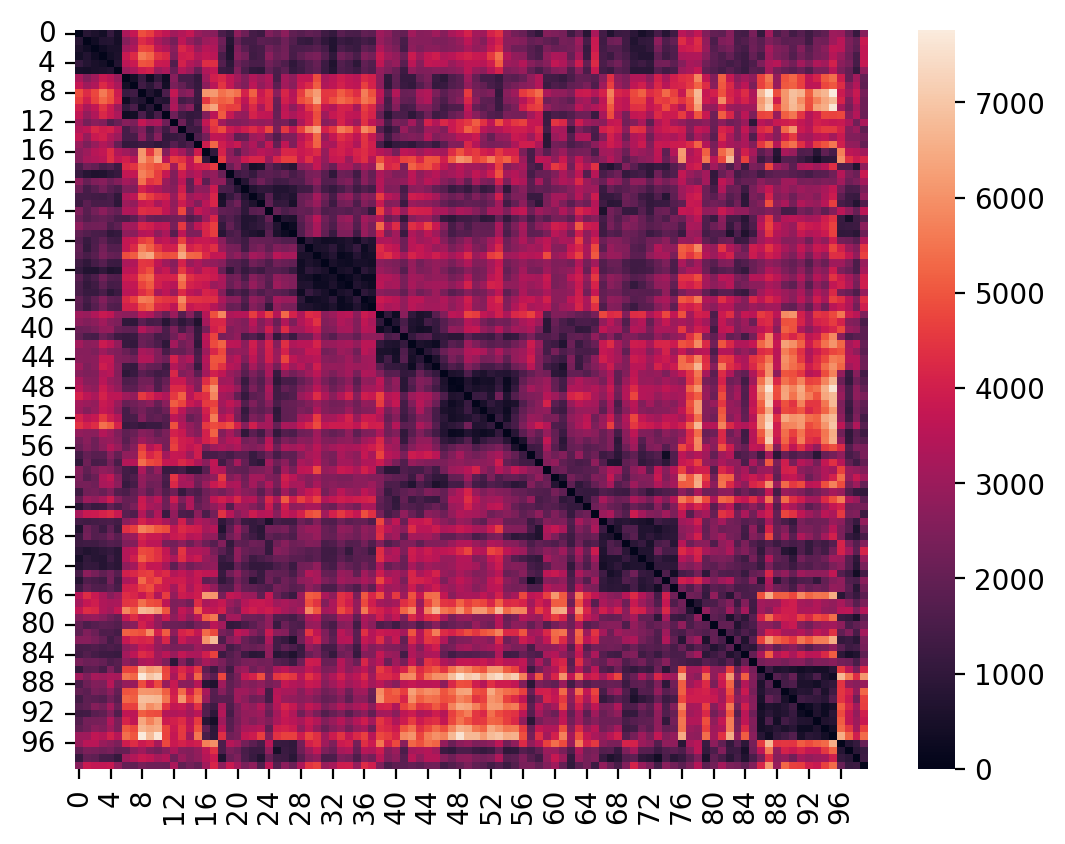

In [38]:
sns.heatmap(pairwise_distances(pred_val[900:1000]))

In [39]:
l = []
for k in neigh.keys():
    l.append(len([1 for x in neigh[k]["artists"] if x == neigh[k]["atrtistid"]]))

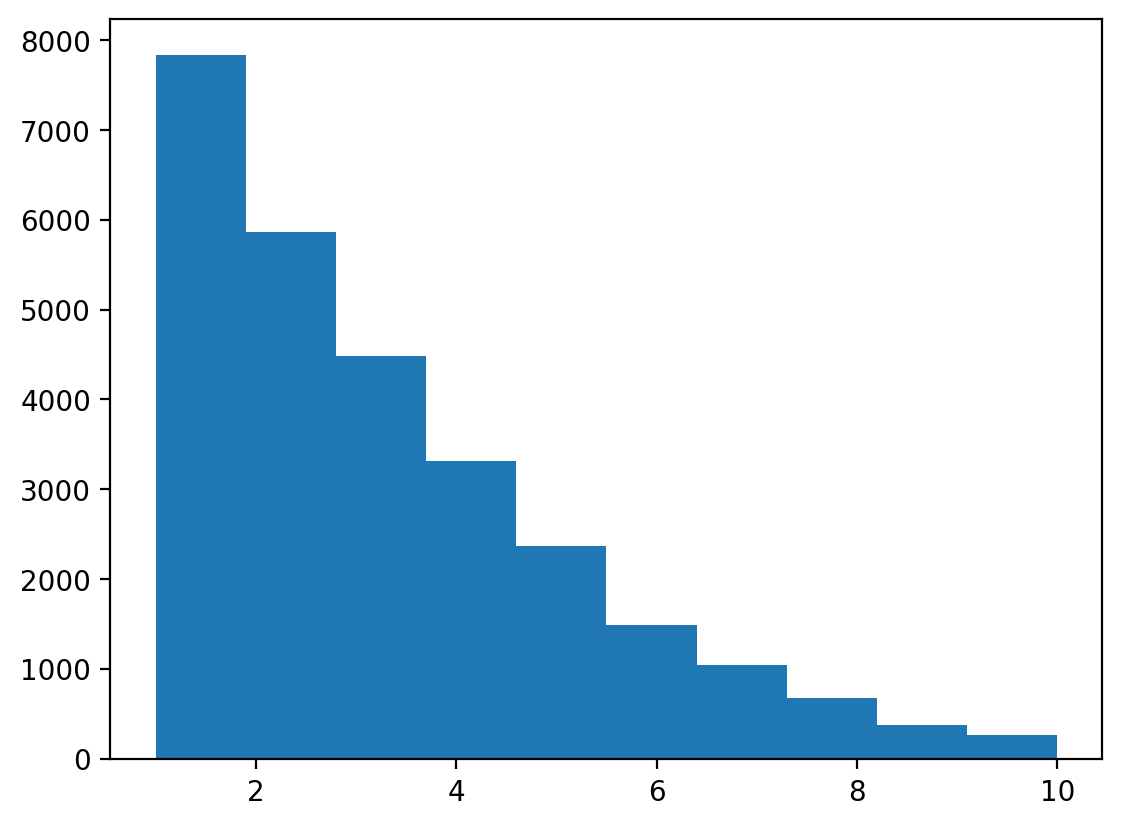

In [40]:
plt.hist(l)
plt.show();

In [41]:
def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list):
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

In [42]:
def eval_submission(tracks_meta, submission, top_size=100):
    track2artist_map = tracks_meta.set_index("trackid")["artistid"].to_dict()
    track2subset_map = tracks_meta.set_index("trackid")["subset"].to_dict()
    artist2tracks_map = tracks_meta.groupby("artistid").agg(list)["trackid"].to_dict()

    ndcg_list = defaultdict(list)
    for _, row in tracks_meta.iterrows():
        query_trackid = row["trackid"]
        ranked_list = submission[query_trackid]["tracks"]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map)
        if ideal_dcg != 0:
            ndcg_list[track2subset_map[query_trackid]].append(dcg / ideal_dcg)

    result = {}
    for subset, values in ndcg_list.items():
        result[subset] = np.mean(values)
    return result

In [43]:
val_df["subset"] = "0"
from collections import defaultdict

In [44]:
r = eval_submission(val_df, neigh)

In [45]:
r

{'0': 0.1410507742300167}